# Example with flow in a channel with a bump

This is a test case with particles released in a simple looping flow field
The depth profile is given by: 

$d(x) = d_m - d_b * bump(x,l_b)$

Where:
- $d_m$ is the mean depth
- $d_b$ is the height of the bump
- $l_b$ is the length of the bump
- $L$ is half the length of the channel
- $u_m$ is the mean flow 

The domain is $x \in [-L,L], y \in [-d_m,0]$


In [1]:
# Load required libraries
using Pkg
Pkg.precompile() # command needed after modifying the src code
Pkg.activate("..")
using Particles
using Plots, LaTeXStrings
using Random
using Printf
using DelimitedFiles

#rng_recursion = MersenneTwister(1234) 

nothing

  Activating project at `d:\Projects\particles.jl`


In [364]:
# Randompool setup and restart
randpool = MersenneTwister(123) #Generate same random numbers every time

# Load default settings 
# collected configuration is in Dict d
d = default_userdata() # start with some defaults
d["rng"] = randpool


MersenneTwister(123)

In [365]:

# settings for this experiment
n = 1 # number of particles
d["nparticles"] = n
d["nparticles_bound"] = n
# problem specific settings
d_b = 4.0
d["d_b"] = d_b # height of the bump [m]
l_b=300.0
d["l_b"] = l_b# length of the bump [m]
d_m=10.0
d["d_m"] = d_m # mean depth [m]
u_m=1.0
d["u_m"] = u_m # mean flow [m/s]
L=500.0
d["L"] = 500.0 # half the length of the channel [m]
# all variables for one particle are collected in a vector
variables = ["x", "y", "z", "age"]
d["variables"] = variables
# initial position of the particles
m = length(variables)
p = zeros(m, n)
p[1, :] = (-0.9*L) .+ 0.01 .* L .* randn(randpool, n, 1) # particles are spawned close to the left boundary
p[3, :] = (-d_m) .+ 1.0 .* d_m .* rand(randpool, n, 1)
d["particles"] = p # initial values
# simulation time
d["dt"] = 1.0     #time-step
d["tstart"] = 1.0 
d["tend"] = 200.0 #800
tend=d["tend"]
# write to netcdf
d["write_maps_times"] = collect(d["tstart"]:d["dt"]:d["tend"])
d["write_maps"] = false #do not write to netcdf
d["write_maps_filename"] = "output_loop.nc"
# write plots to file
d["plot_maps_times"] = collect(d["tstart"]:d["dt"]:d["tend"])
d["plot_maps"] = false # do not make png figures
d["plot_maps_size"]=(900,300)
d["plot_maps_func"] = plot_maps_xz

# keep some output in memory
d["keep_particles"] = true #keep results in memory (bad idea for a large run)
d["keep_particle_times"] = collect(d["tstart"]:d["dt"]:d["tend"])

nothing



Two test cases are embedded.
The first test case tests the algorithm that divides the timestep by half, takes a new random number and thus weakens the strength of diffusion strength and "controlls" the direction of turbulent velocity. To test the algorithm, we only add one particle into the computation domain and set the keyword parameter `d["is_cross_bc"] = false` and `d["is_apply_cross_bc_test"] = true`.

In [366]:
d["particles"] = zeros(length(variables), d["nparticles_bound"])
d["is_particles_active"] = falses(d["nparticles_bound"],)
d["is_keep_these_particles"] = trues(d["nparticles_bound"],)

# the following options are to be added in the default_userdata() function
# if to apply the algorithm to prevent the algorithm from crossing the boundary or not
d["is_cross_bc"] = false # if added, the algorithm will terminate once the particle is out of the boundary
d["is_apply_cross_bc_test"] = true # if applied, only one particle is used and all virtual trajectories are also recorded
if d["is_apply_cross_bc_test"]
    d["the_virtual_trajectory"] = d["particles"]
end
# to be added according to the actual problem
d["isactive_particles"] = trues(d["nparticles_bound"],) # check if particles move out of the is_particle_in_domain
d["recursion_depth"] = 10

# to be added according to the actual problem
d["is_particle_in_domain"] = x -> nothing

# magnitude of the diffusion profile
K_MAG = 0.1
# set figname
figbkg="single_particle_test_result\\bkg_K=$(K_MAG).png"
figname="single_particle_test_result\\selected_results\\sprt_K=$(K_MAG).png"

"single_particle_test_result\\selected_results\\sprt_K=0.1.png"

In [367]:
# function to implement void IC and forcing conditions
d["first_active_index"] = 1
d["first_inactive_index"] = 2

function initialize_particles(d,p)
    # if initialize particle location to perform the single particle test
    #p = [-452.01034034514936,0.0,-8.633525058830664,0.0] # will end up hitting the lower boundary
    #p = [-452.01034034514936,0.0,-1.833525058830664,0.0]
    p = [-200.01034034514936,0.0,-8.53525058830664,10.0] # will end up hitting the lower boundary
    return  reshape(p, length(p), 1)
end
d["initialize_particles"] = initialize_particles

function release_particles(d,p,t)
    return p
end
d["release_particles"] = release_particles

release_particles (generic function with 1 method)

In [368]:
d #show configuration

Dict{String, Any} with 43 entries:
  "write_maps"             => false
  "is_apply_cross_bc_test" => true
  "release_particles"      => release_particles
  "dt"                     => 1.0
  "variables"              => ["x", "y", "z", "age"]
  "keep_particle_times"    => [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.…
  "plot_maps_size"         => (900, 300)
  "l_b"                    => 300.0
  "is_cross_bc"            => false
  "u_m"                    => 1.0
  "is_particles_active"    => Bool[0]
  "tstart"                 => 1.0
  "plot_maps_folder"       => "output"
  "plot_maps_prefix"       => "map"
  "reftime"                => DateTime("2000-01-01T00:00:00")
  "nparticles"             => 1
  "tend"                   => 200.0
  "write_maps_as_series"   => true
  "nparticles_bound"       => 1
  ⋮                        => ⋮

In [369]:
p

4×1 Matrix{Float64}:
 -444.0486605950686
    0.0
   -0.594849992848129
    0.0

In [370]:
d["particles"]

4×1 Matrix{Float64}:
 0.0
 0.0
 0.0
 0.0

In [371]:
# Define the flow field

# bump function
function bump(x, l_b)
    if abs(x) < l_b
        return 0.5 * (1.0 + cos(pi * x / l_b))
    else
        return 0.0
    end
end

function derivative_bump(x, l_b)
    if abs(x) < l_b
        return -0.5 * pi / l_b * sin(pi * x / l_b)
    else
        return 0.0
    end
end

# depth profile
function depth(x, d_m, d_b, l_b)
    d_m - d_b * bump(x, l_b)
end


# derivative of depth profile
function derivative_depth(x, d_m, d_b, l_b)
    -d_b * derivative_bump(x, l_b)
end

# Stream function with value 0 at the surface and u_m * d_m at the bottom
# Note that the depth is variable
function stream(x, y, z, t)
    d_m = d["d_m"]
    d_b = d["d_b"]
    l_b = d["l_b"]
    u_m = d["u_m"]
    d_x = depth(x, d_m, d_b, l_b) # depth at x
    if z>0.0
        return 0.0
    elseif z<-d_x
        return -u_m * d_m
    else
        return -u_m * d_m * z / d_x
    end
end

# flow in x direction (for now has to be called u)
function u(x, y, z, t)
    # u=-s_z
    d_m = d["d_m"]
    d_b = d["d_b"]
    l_b = d["l_b"]
    u_m = d["u_m"]
    d_x = depth(x, d_m, d_b, l_b) # depth at x
    if z>0.0
        return 0.0
    elseif z<-d_x
        return 0.0
    else
        return u_m * d_m / d_x
    end
end


# flow in y direction (for now has to be called v)
function v(x, y, z, t)
    return 0.0
end

# flow in y direction (for now has to be called w)
function w(x, y, z, t)
   # w=s_x
   d_m = d["d_m"]
   d_b = d["d_b"]
   l_b = d["l_b"]
   u_m = d["u_m"]
   d_x = depth(x, d_m, d_b, l_b) # depth at x
   if z>0.0
       return 0.0
   elseif z<-d_x
       return 0.0
   else
       return u_m * d_m * z / d_x^2 * derivative_depth(x, d_m, d_b, l_b)
   end
end

nothing

In [372]:
# implement that function that identifies whether the particle is currently
# inside the particle or not
function is_particle_in_domain(p)
    x,_,z,_ = p
    is_inside_xdir = x>-500 && x<500
    is_inside_zdir = (z<=0) && (z+depth(x, d_m, d_b, l_b)>=0) 
    return is_inside_xdir && is_inside_zdir, !is_inside_zdir
end
d["is_particle_in_domain"] = is_particle_in_domain

is_particle_in_domain (generic function with 1 method)

In [373]:
# add diffusion profile
function parabola_diffusion(z)
    H = 1 # unit length water column
    if z<=H && z>=0
        return 6 * z  * (1-z) * K_MAG
    else
        return 0
    end
end

# add diffusion profile
function derivative_parabola_diffusion(z)
    H = 1 # unit length water column
    if z<=H && z>=0
        return (6 - 12 *z) * K_MAG
    else 
        return 0
    end
end

function double_parabola_diffusion(z,a=1, magnitude=1.0)
    # input with reference coordinate z, shape parameter a and magnitude z
    H = 1 # unit length water column
    c = 2*(1+a)*(1+2*a)/(a*a*H^(1+1/a))
    if z>=0 && z<=H/2
        return magnitude* c *z*(H-2*z)^(1/a)
    else
        return magnitude* c *(H-z)*(2*z-1)^(1/a)
    end
end

function derivative_double_parabola_diffusion(z, a=1, magnitude=1.0)
    # input with reference coordinate z, shape parameter a and magnitude z
    H = 1 # unit length water column
    c = 2*(1+a)*(1+2*a)/(a*a*H^(1+1/a))
    if z>=0 && z<=H/2
        return magnitude*c*( z/a*(H-2*z)^(1/a-1)*(-2) + (H-2*z)^(1/a) )
    else
        return magnitude*c*( (H-z)/a*(2*z-1)^(1/a-1)*(2) + (-1)*(2*z-1)^(1/a)  ) 
    end
end

## keep g unchanged
 

## compute local coordinates

## dW



derivative_double_parabola_diffusion (generic function with 3 methods)

In [374]:
# plot the diffusion function
z = 0:0.05:1.0
K = similar(z)
dKdz = similar(z)
for i in 1:length(z)
    K[i] = parabola_diffusion(z[i])
    dKdz[i] = derivative_parabola_diffusion(z[i])
end
l = @layout([a b]);
p1 = plot(K,z, label="diffusion")
p2 = plot(dKdz, z, label="derivative")
plot(p1,p2,size=(600,300),layout=l,dpi=300)
savefig("single_particle_test_result\\selected_results\\diffusion_profile.png")


"d:\\Projects\\particles.jl\\example_notebooks\\single_particle_test_result\\selected_results\\diffusion_profile.png"

In [375]:
#plot flow field

#grid for plotting
d_m=d["d_m"];L=d["L"];u_m=d["u_m"]
xgrid=-L:(L/30):L
zgrid=-d_m:(d_m/10):0.0
nx=length(xgrid)
nz=length(zgrid)
xs=repeat(xgrid,1,nz)
zs=repeat(zgrid,1,nx)'

Plots.default(:size, d["plot_maps_size"])
scale_u=1.0
scale_w=1.0

#heatmap(xgrid,zgrid,w.(xs,0.0,zs,0.0)')
quiver(vec(xs),vec(zs),quiver=(scale_u*u.(vec(xs),0.0,vec(zs),0.0),scale_w*w.(vec(xs),0.0,vec(zs),0.0)),
    arrowscale=0.6, headsize=0.1)
plot!(xgrid,-depth.(xgrid,d_m,d_b,l_b),lw=2.0,lc=:black,label="depth")
plot!(xgrid,0.0*xgrid,lw=2.0,lc=:blue,label="surface")
savefig(".\\single_particle_test_result_bkg.png")

"d:\\Projects\\particles.jl\\example_notebooks\\single_particle_test_result_bkg.png"

In [376]:
# Here is the equation that we want to solve for the particles

"""
   !f(ds,s,t,i,d)

Dynamic model, computes time derivative ds of s at current time t
for particle i and possibly using data/functions from d of type userdata.
"""
function f!(∂s, s, t, i, d)
   x, y, z, age = s
   # dx/dt=u
   ∂s.x = u(x, y, z, t)
   # dy/dt=v
   ∂s.y = v(x, y, z, t)
   # dz/dt=0
   depth_z = depth(x, d_m, d_b, l_b)
   z_nd = (z+depth_z)/depth_z 
   #z_nd = (z+d_m)/d_m #d_m is the depth of the computation domain
   if z_nd<=1 && z_nd>=0
      ∂s.z = w(x,y,z,t) + derivative_parabola_diffusion(z_nd) 
   else
      ∂s.z = 0
   end
   # age=(t-t0)
   ∂s.t = 1.0
end

"""
   !g(ds,s,t,i,d)

   Dynamic model, computes as ds the function g in the equation ds=f(s,t)dt+g(s,t)dw 
   for s at current time t for particle i and possibly using data/functions from d of type userdata.
"""
function g!(∂s, s, t, i, d)
   x, y, z, age = s
   # dx/dt=u
   ∂s.x = 0.0
   # dy/dt=v
   ∂s.y = 0.0
   # dz/dt=0
   depth_z = depth(x, d_m, d_b, l_b)
   z_nd = (z+depth_z)/depth_z 
   #z_nd = (z+d_m)/d_m 
   if z_nd<=1 && z_nd>=0
      ∂s.z = sqrt(2 * parabola_diffusion(z_nd)) * randn(randpool)
   else
      ∂s.z = 0
   end
   # age=(t-t0)
   ∂s.t = 0.0
end
d["f"] = f!
d["g"] = g!


g! (generic function with 1 method)

In [377]:
# use streamfunction as background for plotting

function plot_background(d)
    L = d["L"]
    # streamfunction for plot
     x1 = -L:(L/100):L
     z1 = -d_m:(d_m/100):0.0
     flow = zeros(length(x1), length(z1))
     for i = 1:length(x1)
         for j = 1:length(z1)
             flow[i,j] = stream(x1[i], 0.0, z1[j], 0.0)
         end
     end
     f = contour(x1, z1, flow', legend=false)
     return(f)
 end
 d["plot_maps_background"] = plot_background
 

plot_background (generic function with 1 method)

In [379]:
run_simulation(d)

writing output to memory at t = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0  …  191.0, 192.0, 193.0, 194.0, 195.0, 196.0, 197.0, 198.0, 199.0, 200.0]
interrupt simulation for output at t = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0  …  191.0, 192.0, 193.0, 194.0, 195.0, 196.0, 197.0, 198.0, 199.0, 200.0]
Simulation from time 1.0s to 200.0s since 2000-01-01T00:00:00
t=1.0 -> 1.0  : 2000-01-01T00:00:01 -> 2000-01-01T00:00:01 : 0.0%
Before this updating, the number of active particle is 1.
Before this updating, the number of released particles is 0


Particles initialization finish!
simulate! runs for once.
t=1.0 -> 2.0  : 2000-01-01T00:00:01 -> 2000-01-01T00:00:02 : 0.5%
Before this updating, the number of active particle is 1.
Before this updating, the number of released particles is 1
simulate! runs for once.
t=2.0 -> 3.0  : 2000-01-01T00:00:02 -> 2000-01-01T00:00:03 : 1.0%
Before this updating, the number of active particle is 1.
Before this updating, the number of released particles is 1
simulate! runs for once.
t=3.0 -> 4.0  : 2000-01-01T00:00:03 -> 2000-01-01T00:00:04 : 1.5%
Before this updating, the number of active particle is 1.
Before this updating, the number of released particles is 1
simulate! runs for once.
t=4.0 -> 5.0  : 2000-01-01T00:00:04 -> 2000-01-01T00:00:05 : 2.0%
Before this updating, the number of active particle is 1.
Before this updating, the number of released particles is 1
simulate! runs for once.
t=5.0 -> 6.0  : 2000-01-01T00:00:05 -> 2000-01-01T00:00:06 : 2.5%
Before this updating, the number of act

simulate! runs for once.
t=35.0 -> 36.0  : 2000-01-01T00:00:35 -> 2000-01-01T00:00:36 : 17.6%
Before this updating, the number of active particle is 1.
Before this updating, the number of released particles is 1
simulate! runs for once.
t=36.0 -> 37.0  : 2000-01-01T00:00:36 -> 2000-01-01T00:00:37 : 18.1%
Before this updating, the number of active particle is 1.
Before this updating, the number of released particles is 1
simulate! runs for once.
t=37.0 -> 38.0  : 2000-01-01T00:00:37 -> 2000-01-01T00:00:38 : 18.6%
Before this updating, the number of active particle is 1.
Before this updating, the number of released particles is 1
simulate! runs for once.
t=38.0 -> 39.0  : 2000-01-01T00:00:38 -> 2000-01-01T00:00:39 : 19.1%
Before this updating, the number of active particle is 1.
Before this updating, the number of released particles is 1
simulate! runs for once.
t=39.0 -> 40.0  : 2000-01-01T00:00:39 -> 2000-01-01T00:00:40 : 19.6%
Before this updating, the number of active particle is 1.


Before this updating, the number of active particle is 1.
Before this updating, the number of released particles is 1
simulate! runs for once.
t=84.0 -> 85.0  : 2000-01-01T00:01:24 -> 2000-01-01T00:01:25 : 42.2%
Before this updating, the number of active particle is 1.
Before this updating, the number of released particles is 1
simulate! runs for once.
t=85.0 -> 86.0  : 2000-01-01T00:01:25 -> 2000-01-01T00:01:26 : 42.7%
Before this updating, the number of active particle is 1.
Before this updating, the number of released particles is 1
simulate! runs for once.
t=86.0 -> 87.0  : 2000-01-01T00:01:26 -> 2000-01-01T00:01:27 : 43.2%
Before this updating, the number of active particle is 1.
Before this updating, the number of released particles is 1
simulate! runs for once.
t=87.0 -> 88.0  : 2000-01-01T00:01:27 -> 2000-01-01T00:01:28 : 43.7%
Before this updating, the number of active particle is 1.
Before this updating, the number of released particles is 1
simulate! runs for once.
t=88.0 ->


Before this updating, the number of active particle is 1.
Before this updating, the number of released particles is 1
simulate! runs for once.
t=132.0 -> 133.0  : 2000-01-01T00:02:12 -> 2000-01-01T00:02:13 : 66.3%
Before this updating, the number of active particle is 1.
Before this updating, the number of released particles is 1
simulate! runs for once.
t=133.0 -> 134.0  : 2000-01-01T00:02:13 -> 2000-01-01T00:02:14 : 66.8%
Before this updating, the number of active particle is 1.
Before this updating, the number of released particles is 1
simulate! runs for once.
t=134.0 -> 135.0  : 2000-01-01T00:02:14 -> 2000-01-01T00:02:15 : 67.3%
Before this updating, the number of active particle is 1.
Before this updating, the number of released particles is 1
simulate! runs for once.
t=135.0 -> 136.0  : 2000-01-01T00:02:15 -> 2000-01-01T00:02:16 : 67.8%
Before this updating, the number of active particle is 1.
Before this updating, the number of released particles is 1
simulate! runs for once.



Before this updating, the number of active particle is 1.
Before this updating, the number of released particles is 1
simulate! runs for once.
t=180.0 -> 181.0  : 2000-01-01T00:03:00 -> 2000-01-01T00:03:01 : 90.5%
Before this updating, the number of active particle is 1.
Before this updating, the number of released particles is 1
simulate! runs for once.
t=181.0 -> 182.0  : 2000-01-01T00:03:01 -> 2000-01-01T00:03:02 : 91.0%
Before this updating, the number of active particle is 1.
Before this updating, the number of released particles is 1
simulate! runs for once.
t=182.0 -> 183.0  : 2000-01-01T00:03:02 -> 2000-01-01T00:03:03 : 91.5%
Before this updating, the number of active particle is 1.
Before this updating, the number of released particles is 1
simulate! runs for once.
t=183.0 -> 184.0  : 2000-01-01T00:03:03 -> 2000-01-01T00:03:04 : 92.0%
Before this updating, the number of active particle is 1.
Before this updating, the number of released particles is 1
simulate! runs for once.


In [380]:
d["the_virtual_trajectory"]

4×200 Matrix{Float64}:
 -200.01     -198.899    -197.786    …   85.3388    86.821     88.2978
    0.0         0.0         0.0           0.0        0.0        0.0
   -8.53525    -7.70108    -7.07866      -2.57067   -2.81098   -2.73587
   10.0        11.0        12.0         207.0      208.0      209.0

In [381]:
p = d["particles"]

4×1 Matrix{Float64}:
  88.29784441916942
   0.0
  -2.735866194684945
 209.0

In [382]:
d["particles"] = reshape([1,2,3,4],4,1)

4×1 Matrix{Int64}:
 1
 2
 3
 4

In [384]:
fig2 = d["plot_maps_background"](d)
savefig(fig2, figbkg)


"d:\\Projects\\particles.jl\\example_notebooks\\single_particle_test_result\\bkg_K=0.1.png"

In [385]:
d["all_particles"]

201-element Vector{Any}:
 [-200.01034034514936; 0.0; -8.53525058830664; 10.0;;]
 [0.0; 0.0; 0.0; 0.0;;]
 [-198.89925238753744; 0.0; -7.701080473807155; 11.0;;]
 [-197.78566275426147; 0.0; -7.078664538973438; 12.0;;]
 [-196.669537901615; 0.0; -6.891350533033493; 13.0;;]
 [-195.55084406255972; 0.0; -6.856280600457572; 14.0;;]
 [-194.42954724636667; 0.0; -6.0646353466468; 15.0;;]
 [-193.3056132384169; 0.0; -5.870865381852607; 16.0;;]
 [-192.1790076001704; 0.0; -5.521193646282984; 17.0;;]
 [-191.04969566931263; 0.0; -5.462730071760533; 18.0;;]
 ⋮
 [76.33465413065638; 0.0; -1.1081528823314377; 201.0;;]
 [77.84850061240172; 0.0; -1.6659063223248007; 202.0;;]
 [79.35711605167887; 0.0; -1.871996281564611; 203.0;;]
 [80.86047686869331; 0.0; -2.2768030637766277; 204.0;;]
 [82.358562525011; 0.0; -1.8544806746618026; 205.0;;]
 [83.85135543822213; 0.0; -2.76432000566575; 206.0;;]
 [85.33884089566091; 0.0; -2.570668629390225; 207.0;;]
 [86.82100696745584; 0.0; -2.8109785170947386; 208.0;;]
 [88.2978

In [386]:
d["the_virtual_trajectory"]

4×200 Matrix{Float64}:
 -200.01     -198.899    -197.786    …   85.3388    86.821     88.2978
    0.0         0.0         0.0           0.0        0.0        0.0
   -8.53525    -7.70108    -7.07866      -2.57067   -2.81098   -2.73587
   10.0        11.0        12.0         207.0      208.0      209.0

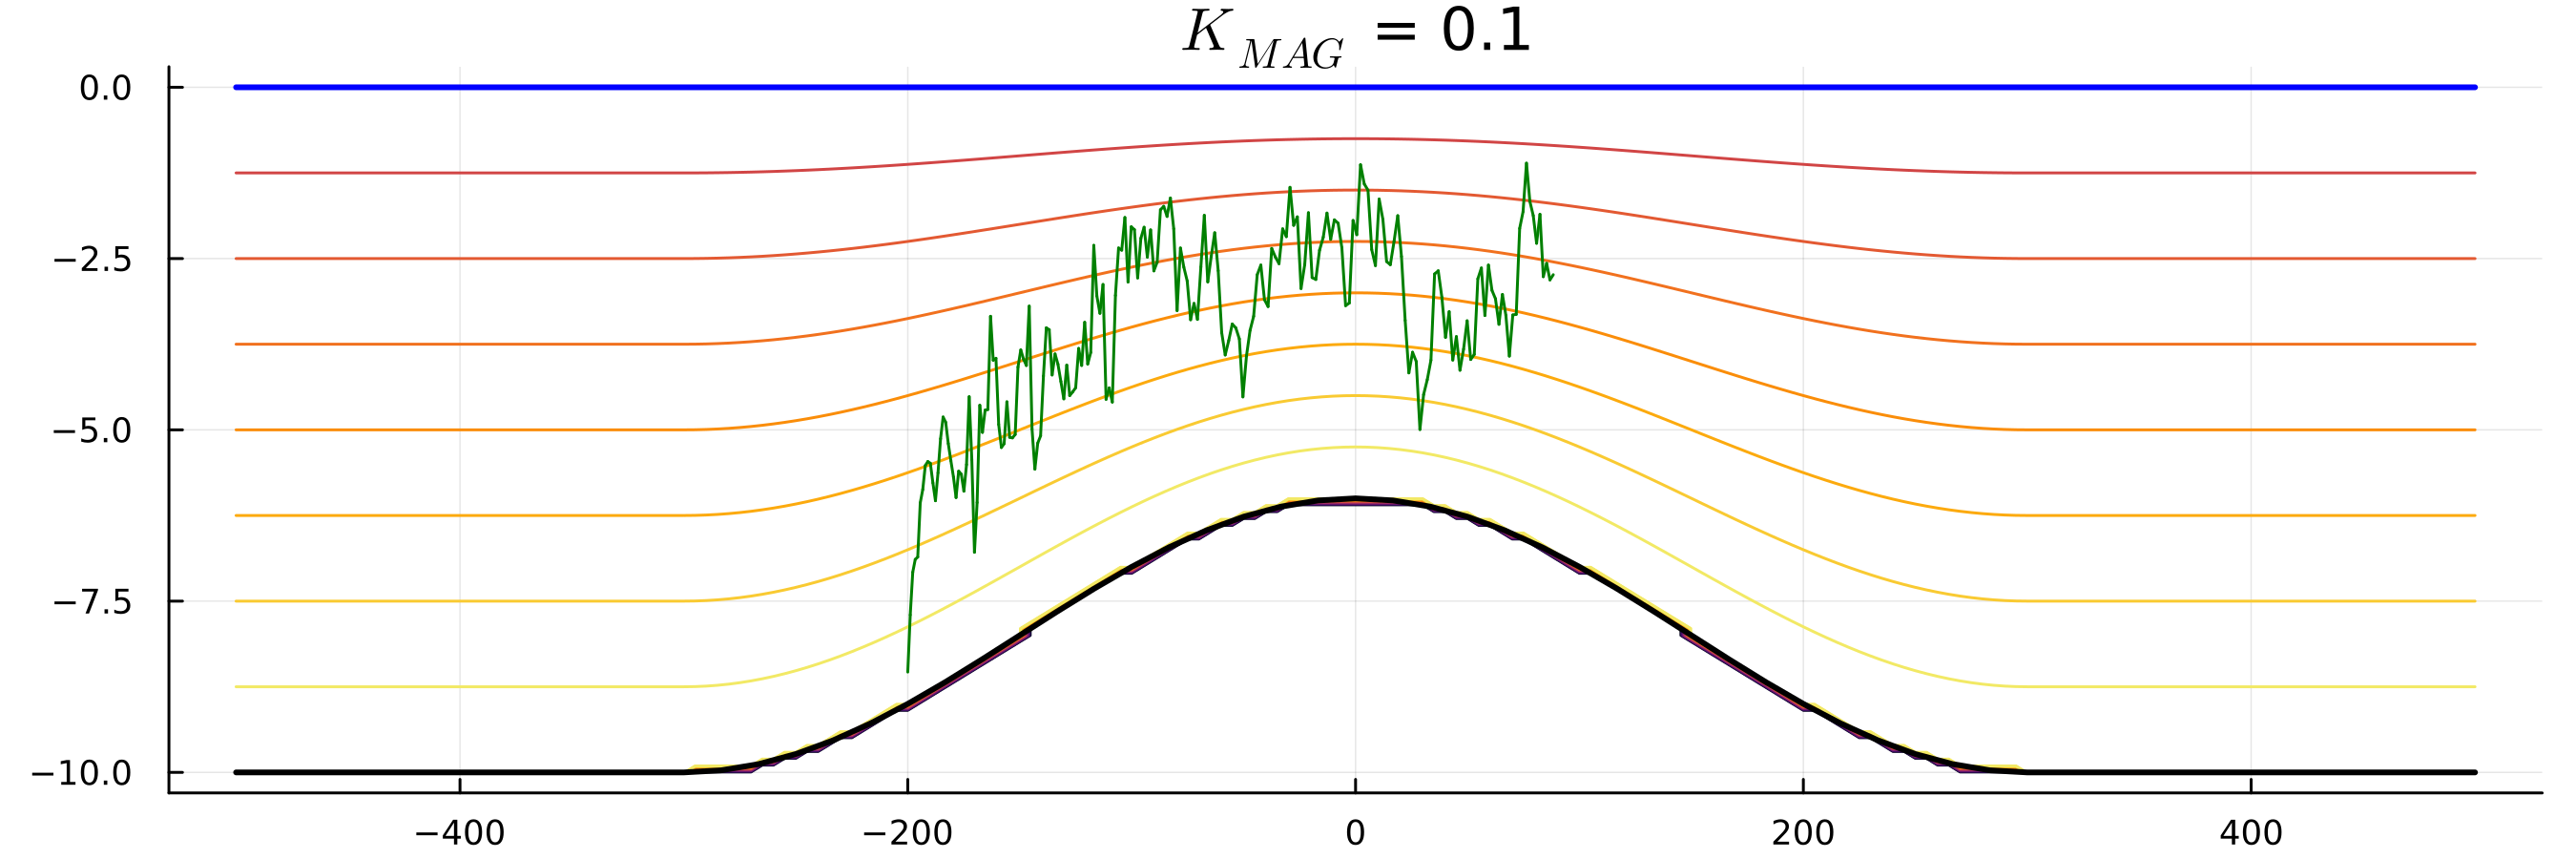

"d:\\Projects\\particles.jl\\example_notebooks\\single_particle_test_result\\selected_results\\sprt_K=0.1.png"

In [387]:
function is_inside(p)
    x,_,z,_ = p
    is_inside_xdir = x>-500 && x<500
    is_inside_zdir = (z<=0) && (z+depth(x, d_m, d_b, l_b)>=0) 
    return is_inside_xdir && is_inside_zdir
end
fig = d["plot_maps_background"](d)
d_b=d["d_b"];l_b=d["l_b"];d_m=d["d_m"]
plot!(fig,xgrid,-depth.(xgrid,d_m,d_b,l_b),lw=2.0,lc=:black,label="depth")
plot!(fig,xgrid,0.0*xgrid,lw=2.0,lc=:blue,label="surface")
t = d["the_virtual_trajectory"]
p = t[:, 1]
for i=2:size(t)[2]
    if is_inside(t[:,i])
        plot!(fig,[p[1],t[1,i]],[p[3],t[3,i]], color=:green, lw=1, dpi=300)
        p = t[:, i] # only update the particle location if it stays inside the domain
        #plot!(label="particle trajectory", legend=:best)
    else
        plot!(fig,[p[1],t[1,i]],[p[3],t[3,i]], color=:red, lw=1, ls=:dot)
    end
end
title!(fig, L"$K_{MAG}$ = "*"$(K_MAG)")
display(fig)
savefig(fig, figname)

In [388]:
# store the velocity trajectory
file_path = "single_particle_test_result\\selected_results\\trajectory_info_K=$(K_MAG).txt"
if K_MAG <= 0.1
    t = d["the_virtual_trajectory"][[1,3],:]
    open(file_path,"w") do io
        writedlm(io, t, ',')
    end
end    

    

In [389]:
d["the_virtual_trajectory"][[1,3],:]

2×200 Matrix{Float64}:
 -200.01     -198.899    -197.786    …  85.3388   86.821    88.2978
   -8.53525    -7.70108    -7.07866     -2.57067  -2.81098  -2.73587

In [390]:
t = d["the_virtual_trajectory"]
p = t


4×200 Matrix{Float64}:
 -200.01     -198.899    -197.786    …   85.3388    86.821     88.2978
    0.0         0.0         0.0           0.0        0.0        0.0
   -8.53525    -7.70108    -7.07866      -2.57067   -2.81098   -2.73587
   10.0        11.0        12.0         207.0      208.0      209.0

In [391]:
d["all_particles"]

201-element Vector{Any}:
 [-200.01034034514936; 0.0; -8.53525058830664; 10.0;;]
 [0.0; 0.0; 0.0; 0.0;;]
 [-198.89925238753744; 0.0; -7.701080473807155; 11.0;;]
 [-197.78566275426147; 0.0; -7.078664538973438; 12.0;;]
 [-196.669537901615; 0.0; -6.891350533033493; 13.0;;]
 [-195.55084406255972; 0.0; -6.856280600457572; 14.0;;]
 [-194.42954724636667; 0.0; -6.0646353466468; 15.0;;]
 [-193.3056132384169; 0.0; -5.870865381852607; 16.0;;]
 [-192.1790076001704; 0.0; -5.521193646282984; 17.0;;]
 [-191.04969566931263; 0.0; -5.462730071760533; 18.0;;]
 ⋮
 [76.33465413065638; 0.0; -1.1081528823314377; 201.0;;]
 [77.84850061240172; 0.0; -1.6659063223248007; 202.0;;]
 [79.35711605167887; 0.0; -1.871996281564611; 203.0;;]
 [80.86047686869331; 0.0; -2.2768030637766277; 204.0;;]
 [82.358562525011; 0.0; -1.8544806746618026; 205.0;;]
 [83.85135543822213; 0.0; -2.76432000566575; 206.0;;]
 [85.33884089566091; 0.0; -2.570668629390225; 207.0;;]
 [86.82100696745584; 0.0; -2.8109785170947386; 208.0;;]
 [88.2978

In [392]:
d["the_virtual_trajectory"]

4×200 Matrix{Float64}:
 -200.01     -198.899    -197.786    …   85.3388    86.821     88.2978
    0.0         0.0         0.0           0.0        0.0        0.0
   -8.53525    -7.70108    -7.07866      -2.57067   -2.81098   -2.73587
   10.0        11.0        12.0         207.0      208.0      209.0

In [393]:
# Specify the file path
file_path = "single_particle_test_result\\selected_results\\velocity_info_K=$(K_MAG).txt"

# Open the file in write mode
file = open(file_path, "w")

m,n = size(d["the_virtual_trajectory"])

for i=1:n
    x,y,z,t = d["the_virtual_trajectory"][:,i]
    depth_z = depth(x, d_m, d_b, l_b)
    z_nd = (z+depth_z)/depth_z 
    #z_nd = (z+d_m)/d_m #d_m is the depth of the computation domain
    if z_nd<=1 && z_nd>=0
       dkdz = derivative_parabola_diffusion(z_nd) 
       diffusion = sqrt(2 * parabola_diffusion(z_nd))
    else
       dkdz = 0
       diffusion = 0
    end
    write(file, @sprintf("%.2f,%.3f,%6.3f,%.3f,%.3f,%.3f\n",t, x, z, w(x,y,z,t), derivative_parabola_diffusion(z_nd), sqrt(2 * parabola_diffusion(z_nd)))      )
    #write(file, @sprintf("t=%.2f, x=%.3f, z=%6.3f, w=%.3f, dkdz=%.3f, sqrt(2k)=%.3f\n",t, x, z, w(x,y,z,t), derivative_parabola_diffusion(z_nd), sqrt(2 * parabola_diffusion(z_nd)))      )
end
close(file)


In [394]:
m,n = size(d["the_virtual_trajectory"])
for i=1:n
    x,y,z,t = d["the_virtual_trajectory"][:,i]
    depth_z = depth(x, d_m, d_b, l_b)
    z_nd = (z+depth_z)/depth_z 
    #z_nd = (z+d_m)/d_m #d_m is the depth of the computation domain
    if z_nd<=1 && z_nd>=0
       dkdz = derivative_parabola_diffusion(z_nd) 
       diffusion = sqrt(2 * parabola_diffusion(z_nd))
    else
       dkdz = 0
       diffusion = 0

       x_old,y_old,z_old,t_old = d["the_virtual_trajectory"][:,i-1]
       depth_z_old = depth(x_old, d_m, d_b, l_b)
       z_nd_old = (z_old+depth_z_old)/depth_z_old  
       @printf("t=%.2f, x=%.3f, z=%6.3f, w=%.3f, dkdz=%.3f, sqrt(2k)=%.3f\n",t_old, x_old, z_old, w(x_old,y_old,z_old,t_old), derivative_parabola_diffusion(z_nd_old), sqrt(2 * parabola_diffusion(z_nd_old)))      
      end
end

In [395]:
d["the_virtual_trajectory"][:,30:35]

4×6 Matrix{Float64}:
 -166.645    -165.447    -164.246    -163.04     -161.832    -160.619
    0.0         0.0         0.0         0.0         0.0         0.0
   -5.03642    -4.71217    -4.70325    -3.34251    -3.98416    -3.95562
   39.0        40.0        41.0        42.0        43.0        44.0

In [396]:
d["the_virtual_trajectory"][:,46:51]

4×6 Matrix{Float64}:
 -147.027    -145.767    -144.503    -143.235    -141.962    -140.685
    0.0         0.0         0.0         0.0         0.0         0.0
   -4.06038    -3.19427    -4.98853    -5.57303    -5.19436    -5.08812
   55.0        56.0        57.0        58.0        59.0        60.0

In [397]:
d["the_virtual_trajectory"][:, 70:75]

4×6 Matrix{Float64}:
 -115.555    -114.184    -112.808    -111.427    -110.041    -108.649
    0.0         0.0         0.0         0.0         0.0         0.0
   -3.04645    -3.29852    -2.87867    -4.55397    -4.38766    -4.59481
   79.0        80.0        81.0        82.0        83.0        84.0

In [398]:
d["the_virtual_trajectory"][:, 76:80]

4×5 Matrix{Float64}:
 -107.253    -105.851    -104.444    -103.032    -101.615
    0.0         0.0         0.0         0.0         0.0
   -3.03788    -2.34572    -2.37726    -1.90091    -2.84176
   85.0        86.0        87.0        88.0        89.0

In [399]:
d["the_virtual_trajectory"][:, 126:131]

4×6 Matrix{Float64}:
 -30.9266   -29.2883   -27.6472   -26.0033   -24.3569  -22.708
   0.0        0.0        0.0        0.0        0.0       0.0
  -2.17976   -1.46055   -2.01449   -1.89136   -2.9371   -2.5879
 135.0      136.0      137.0      138.0      139.0     140.0

In [400]:
d["the_virtual_trajectory"][:, 131:135]

4×5 Matrix{Float64}:
 -22.708   -21.0568   -19.4035  -17.7482   -16.091
   0.0       0.0        0.0       0.0        0.0
  -2.5879   -1.83112   -2.7774   -2.80527   -2.37864
 140.0     141.0      142.0     143.0      144.0

In [401]:
d["the_virtual_trajectory"][:, 141:148]

4×8 Matrix{Float64}:
  -6.11842   -4.4529    -2.78683  …    2.21288    3.8794     5.54561
   0.0        0.0        0.0           0.0        0.0        0.0
  -2.34241   -3.18712   -3.14868      -1.13041   -1.41039   -1.50172
 150.0      151.0      152.0         155.0      156.0      157.0

In [402]:
v_info = readdlm(file_path, ',')
m,n = size(v_info)
plot(1:m, v_info[:,4], label="w", dpi=300)
plot!(1:m, v_info[:,5],label=L"$\frac{dk}{dz}$" * " @ K=$(K_MAG)")
plot!(1:m, v_info[:,6], label= latexstring("\\sqrt{2k}") * " @ K=$(K_MAG)")
savefig("single_particle_test_result\\selected_results\\velocity_info_K=$(K_MAG).png")

"d:\\Projects\\particles.jl\\example_notebooks\\single_particle_test_result\\selected_results\\velocity_info_K=0.1.png"

In [430]:
fig = d["plot_maps_background"](d)
d_b=d["d_b"];l_b=d["l_b"];d_m=d["d_m"]
plot!(fig,xgrid,-depth.(xgrid,d_m,d_b,l_b),lw=2.0,lc=:black,label="depth", dpi=300)
plot!(fig,xgrid,0.0*xgrid,lw=2.0,lc=:blue,label="surface")

K_MAG=0.1
file_path = "single_particle_test_result\\selected_results\\trajectory_info_K=$(K_MAG).txt"
tra = readdlm(file_path, ',', Float64, '\n')
plot!(fig,tra[1,:], tra[2,:], lw=1.0, lc=:black, line=:dash, label=L"$K_{MAG}=$"*"$(K_MAG)")

K_MAG=0.001
file_path = "single_particle_test_result\\selected_results\\trajectory_info_K=$(K_MAG).txt"
tra = readdlm(file_path, ',', Float64, '\n')
plot!(fig,tra[1,:], tra[2,:], lw=1.0, lc=:black, line=:dashdot, label=L"$K_{MAG}=$"*"$(K_MAG)")

K_MAG=0.0
file_path = "single_particle_test_result\\selected_results\\trajectory_info_K=$(K_MAG).txt"
tra = readdlm(file_path, ',', Float64, '\n')
plot!(fig, tra[1,:], tra[2,:], lw=1.0, lc=:black, line=:solid, label=L"$K_{MAG}=$"*"$(K_MAG)", margin=5Plots.mm)
xlabel!("x")
ylabel!("z")
savefig(fig,  "single_particle_test_result\\selected_results\\trajectory_comparison.png")

"d:\\Projects\\particles.jl\\example_notebooks\\single_particle_test_result\\selected_results\\trajectory_comparison.png"

In [404]:
"""
function is_inside(p)
    x,_,z,_ = p
    is_inside_xdir = x>-500 && x<500
    is_inside_zdir = (z<=0) && (z+depth(x, d_m, d_b, l_b)>=0) 
    return is_inside_xdir && is_inside_zdir
end
fig = d["plot_maps_background"](d)
d_b=d["d_b"];l_b=d["l_b"];d_m=d["d_m"]
plot!(fig,xgrid,-depth.(xgrid,d_m,d_b,l_b),lw=2.0,lc=:black,label="depth")
plot!(fig,xgrid,0.0*xgrid,lw=2.0,lc=:blue,label="surface")
t = d["all_particles"]
p = t[1] # Take the trajectory of the first particle out.
for i=2:length(t)
    if is_inside(t[i])
        plot!(fig,[p[1],t[i][1]],[p[3],t[i][3]], color=:green, lw=2)
        p = t[i]
        #plot!(label="particle trajectory", legend=:best)
    else
        plot!(fig,[p[1],t[i][1]],[p[3],t[i][3]], color=:red, lw=2, ls=:dash)
    end
end
display(fig)
"""

"""
# use streamfunction as background for plotting

function plot_background_user(d)
    L = d["L"]
    L = 210
    # streamfunction for plot
     x1 = -L:(L/100):L
     z1 = -d_m:(d_m/100):0.0
     flow = zeros(length(x1), length(z1))
     for i = 1:length(x1)
         for j = 1:length(z1)
             flow[i,j] = stream(x1[i], 0.0, z1[j], 0.0)
         end
     end
     f = contour(x1, z1, flow', legend=false, size=(1200,400))
     return(f)
 end

fig = plot()
xgrid = -210:(210/100):210
zgrid = -d_m:(d_m/100):0.0
fig = plot_background_user(d)
d_b=d["d_b"];l_b=d["l_b"];d_m=d["d_m"]
plot!(fig,xgrid,-depth.(xgrid,d_m,d_b,l_b),lw=2.0,lc=:black,label="depth")
plot!(fig,xgrid,0.0*xgrid,lw=2.0,lc=:blue,label="surface")
t = d["the_virtual_trajectory"]
p = t[:, 1]
for i=2:size(t)[2]
    if is_inside(t[:, i])
        plot!(fig,[p[1],t[1,i]],[p[3],t[3,i]], color=:green, lw=1)
        #plot!(label="particle trajectory", legend=:best)
        p = t[:, i] # only update the particle location if it stays inside the domain
    else
        plot!(fig,[p[1],t[1,i]],[p[3],t[3,i]], color=:red, lw=2, ls=:dot)
    end
end
title!(fig, "K_{MAG} = $(K_MAG)")
display(fig)
savefig(fig, ".//result//particle_hit_ground.svg")
"""
nothing

Core.nothing